# Book recommendations Problem

In [2]:
%matplotlib inline

from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as jnp

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
from tqdm.notebook import tqdm

import scipy
from scipy import linalg

from pathlib import Path
from IPython.display import Markdown, display

SEED = 4212
onp.random.seed(SEED)

In [3]:
ratings_train_full = pd.read_csv("books_data/assignment_ratings_train.csv", low_memory=False)
ratings_test = pd.read_csv("books_data/assignment_ratings_test.csv", low_memory=False)
users = pd.read_csv("books_data/assignment_users.csv", low_memory=False)
books = pd.read_csv("books_data/assignment_books.csv", low_memory=False)

In [3]:
users.head()

,user,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
books.head()

,ISBN,title,author,year
0,0195153448,Classical Mythology,Mark P. O. Morford,2002
1,0002005018,Clara Callan,Richard Bruce Wright,2001
2,0060973129,Decision in Normandy,Carlo D'Este,1991
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999


In [5]:
ratings_train_full.head()

,ratings,user,ISBN
0,5,276726,0155061224
1,3,276729,052165615X
2,8,276736,3257224281
3,6,276737,0600570967
4,7,276744,038550120X


In [4]:
ratings_test.head()

,ratings,user,ISBN
0,6,276729,0521795028
1,9,276747,0060517794
2,8,276747,0679776818
3,6,276748,0747558167
4,3,276762,3453213025


## Train Val Split

Before split our train data into train and validation, we shuffle the data. This is to ensure that we will have some users in our validation set we have seen before. Otherwise, for more complex models we can do no better than predicting the mean of our train set, yielding constant validation loss. After, we split our train data 80-20.


In [5]:
ratings_train_full = ratings_train_full.sample(frac=1, random_state=4212).reset_index(drop=True)
N = ratings_train_full.shape[0]
train = int(0.8*N)
train_ratings = ratings_train_full[:train]
val_ratings = ratings_train_full[train:]

In [8]:
train_ratings.shape

(242855, 3)

In [9]:
val_ratings.shape

(60714, 3)

In [10]:
train_ratings.head()

,ratings,user,ISBN
0,9,253618,0670868361
1,10,148898,0446605239
2,10,81669,0393312836
3,10,104880,0821225987
4,5,11601,0684839571


## 3 Simple Models

First let us try out 3 "naive" approaches to recommendation.

In [8]:
def loss(y, yhat):
    return onp.mean((y-yhat)**2)

### Predict Mean of Train

The first naive method we will use is to simply predict the mean of all train ratings for every entry in our validation and test set, regardless of whether we have seen the user before.

In [6]:
def pred_mean_overall(train, val):
    return onp.full(val.shape[0], onp.mean(train['ratings']))

In [9]:
yhat_mean_train = pred_mean_overall(train_ratings, val_ratings)
mse_mean_train = loss(val_ratings['ratings'], yhat_mean_train)
mse_mean_train

3.4046979358964333

In [10]:
yhat_mean_train_for_test = pred_mean_overall(train_ratings, ratings_test)
test_mse_mean_train = loss(ratings_test['ratings'], yhat_mean_train_for_test)
test_mse_mean_train

3.3811564201714206

This test mse of 3.4 is surprisingly low and could serve as a baseline model for more complex approaches.

### Predict Mean by User

Now we predict the mean of a user's ratings for each user in the validation set we have already seen. For unseen users, we merely predict the mean of the ratings in the train set.

In [11]:
mean_ratings_by_user = train_ratings.groupby(['user'], as_index=False).mean()
mean_ratings_by_user.merge(val_ratings.drop("ratings",axis=1), on="user",how="right")

,user,ratings,ISBN
0,189835,5.119847,0345339681
1,63714,9.292237,1858133335
2,264138,NaN,0425147622
3,125928,6.454545,0553250256
4,182085,8.719064,0425122123
...,...,...,...
60709,130705,7.700000,037572737X
60710,62862,7.433333,0312278586
60711,101641,NaN,014036689X
60712,100459,7.987342,0670839531


In [12]:
def pred_train_user(train, val):
    mean_ratings_by_user = train.groupby(['user'], as_index=False).mean()
    pred_df = mean_ratings_by_user.merge(val.drop("ratings",axis=1), on="user",how="right")
    pred_df.fillna(train['ratings'].mean(), inplace=True)
    return pred_df['ratings'].values

In [13]:
yhat_mean_user = pred_train_user(train_ratings, val_ratings)
mse_mean_user = loss(val_ratings['ratings'], yhat_mean_user)
mse_mean_user

2.954330026192039

In [14]:
yhat_mean_user_test = pred_train_user(train_ratings, ratings_test)
mse_mean_user_test = loss(ratings_test['ratings'], yhat_mean_user_test)
mse_mean_user_test

2.9234237177279754

We can see that this model performs than the naive mean train model: with better val and test mses. Now we move on to trying our last naive model.


### Predict Mean by Book

Finally, we predict the rating using the mean of a book's ratings in the train set. If it is not yet seen, we predict the mean of the train ratings for that book.

In [15]:
def pred_train_book(train, val):
    mean_ratings_by_books = train.groupby(['ISBN'], as_index=False).mean()
    pred_df = mean_ratings_by_books.merge(val.drop("ratings",axis=1), on="ISBN",how="right")
    pred_df.fillna(train['ratings'].mean(), inplace=True)
    return pred_df['ratings'].values

In [16]:
yhat_mean_book = pred_train_book(train_ratings, val_ratings)
mse_mean_book = loss(val_ratings['ratings'], yhat_mean_book)
mse_mean_book

3.863419587287113

In [17]:
yhat_mean_book = pred_train_book(train_ratings, ratings_test)
mse_mean_book = loss(ratings_test['ratings'], yhat_mean_book)
mse_mean_book

3.8180860709244135

Here we see that the results on the val set is actually worse than using the mean by users, but the results on the test set is 
actually better!

## Reversion to the Mean


Now we consider the regularised estimate to improve on our naive models: 
$$
\hat{R}_{u,b} = \frac{1}{\alpha + |F(u)|} (\alpha M + \sum_{b\in{F(u)}}R_{(u,b)})
$$
where 
$M$ is the total mean of all the ratings, $F(u)$ is the set of books rated by user $u$, and $\alpha > 0$ is a parameter of the model.
First we define some functions that help train this model.

### Reversion to the Mean functions

We note that below, for combining train and val/test sets, we **CANNOT** use the default pandas merge to merge the test
data with the R hat dataframe created, as this uses an inner join that would drop all users present in the test/val set 
that were not seen in the train set. Thus we use an outer join. Sanity checks that this aim is indeed achieved are done by
comparing the number of unique users in the merged set and the val/test set, and by comparing the number of rows 
in the val set and the merged set. These should match exactly.

In [18]:
def loss(y, yhat):
    return onp.mean((y-yhat)**2)

def rev_R_hat(alpha, M, Fu_cardinality, sum_R_ub):
    '''
    naive approach
    '''
    frac = 1/(alpha + Fu_cardinality)
    return frac*(alpha*M + sum_R_ub)

def rev_R_hat_vectorised(alpha, M, Fu_cardinality, sum_R_ub) -> onp.array:
    '''
    calculates R hat, but uses numpy arrays to do vectorised operations.
    Note: Assumes all except M and alpha are numpy vectors.
    '''
    # sanity check
    assert Fu_cardinality.shape == sum_R_ub.shape
    
    # make alpha and M into vectors
    alpha_vec = alpha*onp.ones(sum_R_ub.shape)
    alphaM_vec = M*alpha_vec
    
    # put it all together
    frac = 1/(alpha + Fu_cardinality)
    return frac*(alphaM_vec + sum_R_ub)

def reversion_train_tune_alphas(train, val, alphas=[1,3,5,9], column_for_reversion='user', verbose=False):
    '''
    assumes train and val are dfs with the same columns as ratings_train.
    assumes alphas is a list.
    
    Idea here is to use train to come up with ratings for already existing users
    otherwise for new users we predict M for all their ratings
    '''
    # init useful vars
    best_alpha = alphas[0]
    min_loss = 10000
    cv_loss_history = list()
    
    # vec denotes numpy.array
    # all this is for the calculation of R_hat
    M = train['ratings'].mean()
    Fu_size_vec = train.groupby(column_for_reversion).size().values 
    sum_rating_df = train.groupby(column_for_reversion).sum()
    sum_R_ub_vec = sum_rating_df['ratings'].values
    for a in tqdm(alphas):
        
        # get R hat from train
        R_hat_vec = rev_R_hat_vectorised(a, M, Fu_size_vec, sum_R_ub_vec)
        
        # put into df so can combine with val data, 
        # and assign default value, to new users
        train_R_hat_df = pd.DataFrame({column_for_reversion:sum_rating_df.index, 'R_hat':R_hat_vec})
        
        # here we merge using an outer join, as we want to 
        # keep unseen users in val set and predict M for their ratings.
        # but since its an outer join, we also have to handle NaNs in ratings column
        merged_df = train_R_hat_df.merge(val, on=column_for_reversion, how="outer")
        merged_df = merged_df[merged_df['ratings'].notna()]
        
        # sanity check (testing)
        # print(merged_df['R_hat'])
        # print(len(merged_df[column_for_reversion].unique()) == len(val[column_for_reversion].unique()))
        # print(len(merged_df) == len(val))
        
        # store loss
        cv_loss = loss(merged_df['R_hat'].fillna(M), merged_df['ratings'])
        cv_loss_history.append(cv_loss)
        # update and print
        if cv_loss < min_loss:
            min_loss = cv_loss
            best_alpha = a
        if verbose:
            print("New Users: ", merged_df['R_hat'].isna().sum())
            print("Alpha: ", a)
            print("CV Error: ", cv_loss)
            print("Best Alpha: ", best_alpha)
            print("==============")
            
    return best_alpha, cv_loss_history

def reversion_on_new_data(train, test, alpha, column_for_reversion='user'):
    '''
    assumes train and test are dfs with the same columns as ratings_train.
    assumes alphas is a list.
    
    Idea here is to use train to come up with ratings for already existing users
    otherwise for new users we predict M for all their ratings
    '''
    # vec denotes numpy.array
    # all this is for the calculation of R_hat
    M = train['ratings'].mean()
    Fu_size_vec = train.groupby(column_for_reversion).size().values 
    sum_rating_df = train.groupby(column_for_reversion).sum()
    sum_R_ub_vec = sum_rating_df['ratings'].values
    
    # get R hat from train
    R_hat_vec = rev_R_hat_vectorised(alpha, M, Fu_size_vec, sum_R_ub_vec)

    # put into df so can combine with val data, 
    # and assign default value, to new users
    train_R_hat_df = pd.DataFrame({column_for_reversion:sum_rating_df.index, 'R_hat':R_hat_vec})

    # here we merge using an outer join, as we want to 
    # keep unseen users in val set and predict M for their ratings.
    # but since its an outer join, we also have to handle NaNs in ratings column
    merged_df = train_R_hat_df.merge(test, on=column_for_reversion, how="outer")
    merged_df = merged_df[merged_df['ratings'].notna()]

    # sanity check (testing)
    # print(merged_df['R_hat'])
    # print(len(merged_df[column_for_reversion].unique()) == len(test[column_for_reversion].unique()))
    # print(len(merged_df) == len(test))

    # store loss
    test_loss = loss(merged_df['R_hat'].fillna(M), merged_df['ratings'])
    
    return test_loss

def reversion_on_new_data_predict_df(train, test, alpha, column_for_reversion='user') -> pd.DataFrame:
    '''
    assumes train and test are dfs with the same columns as ratings_train.
    assumes alphas is a list.
    
    Idea here is to use train to come up with ratings for already existing users
    otherwise for new users we predict M for all their ratings
    
    This is a prediction function.
    '''
    # vec denotes numpy.array
    # all this is for the calculation of R_hat
    M = train['ratings'].mean()
    Fu_size_vec = train.groupby(column_for_reversion).size().values 
    sum_rating_df = train.groupby(column_for_reversion).sum()
    sum_R_ub_vec = sum_rating_df['ratings'].values
    
    # get R hat from train
    R_hat_vec = rev_R_hat_vectorised(alpha, M, Fu_size_vec, sum_R_ub_vec)

    # put into df so can combine with val data, 
    # and assign default value, to new users
    train_R_hat_df = pd.DataFrame({column_for_reversion:sum_rating_df.index, 'R_hat':R_hat_vec})

    # here we merge using an outer join, as we want to 
    # keep unseen users in val set and predict M for their ratings.
    # but since its an outer join, we also have to handle NaNs in ratings column
    merged_df = train_R_hat_df.merge(test, on=column_for_reversion, how="outer")
    merged_df = merged_df[merged_df['ratings'].notna()]

    # sanity check (testing)
    # print(merged_df['R_hat'])
    # print(len(merged_df[column_for_reversion].unique()) == len(test[column_for_reversion].unique()))
    # print(len(merged_df) == len(test))
    # sanity check that no other values are NaN
    # print(merged_df.info())
    
    merged_df.fillna(M, inplace=True)
    print("Loss on new data: ",loss(merged_df['R_hat'], merged_df['ratings']))
    
    return merged_df

### User Reversion to the Mean

#### Tuning

In [19]:
M = train_ratings['ratings'].mean()
alpha_list = [0.1,0.5,1,2,3,4,5,6,7,M,8,9,10,15]
ba, history = reversion_train_tune_alphas(train_ratings, val_ratings, alphas=alpha_list, \
                                              column_for_reversion='user', verbose=True)

  0%|          | 0/14 [00:00<?, ?it/s]

New Users:  8295
Alpha:  0.1
CV Error:  2.917959152008754
Best Alpha:  0.1
New Users:  8295
Alpha:  0.5
CV Error:  2.8361857494518294
Best Alpha:  0.5
New Users:  8295
Alpha:  1
CV Error:  2.794208854003007
Best Alpha:  1
New Users:  8295
Alpha:  2
CV Error:  2.768210153864162
Best Alpha:  2
New Users:  8295
Alpha:  3
CV Error:  2.765149268632464
Best Alpha:  3
New Users:  8295
Alpha:  4
CV Error:  2.7690567862756756
Best Alpha:  3
New Users:  8295
Alpha:  5
CV Error:  2.775535681764731
Best Alpha:  3
New Users:  8295
Alpha:  6
CV Error:  2.782985960958171
Best Alpha:  3
New Users:  8295
Alpha:  7
CV Error:  2.790731684156112
Best Alpha:  3
New Users:  8295
Alpha:  7.60264355273723
CV Error:  2.7954043476124424
Best Alpha:  3
New Users:  8295
Alpha:  8
CV Error:  2.7984629022627416
Best Alpha:  3
New Users:  8295
Alpha:  9
CV Error:  2.806032587361147
Best Alpha:  3
New Users:  8295
Alpha:  10
CV Error:  2.813372154793762
Best Alpha:  3
New Users:  8295
Alpha:  15
CV Error:  2.84616203

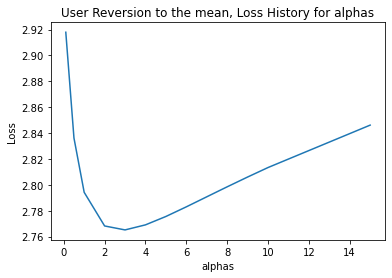

In [20]:
plt.plot(alpha_list,history)
plt.xlabel('alphas')
plt.ylabel('Loss')
plt.title("User Reversion to the mean, Loss History for alphas")
plt.show()

Now that we know the rough area of the minimum, let us test more finely within the range of 2-3.

In [21]:
refined_list_alphas=[2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]
best_alpha_user, history_v2 = reversion_train_tune_alphas(train_ratings, val_ratings, alphas=refined_list_alphas, \
                                              column_for_reversion='user', verbose=True)

  0%|          | 0/11 [00:00<?, ?it/s]

New Users:  8295
Alpha:  2
CV Error:  2.768210153864162
Best Alpha:  2
New Users:  8295
Alpha:  2.1
CV Error:  2.7673224616280234
Best Alpha:  2.1
New Users:  8295
Alpha:  2.2
CV Error:  2.7666056703478636
Best Alpha:  2.2
New Users:  8295
Alpha:  2.3
CV Error:  2.766040336383356
Best Alpha:  2.3
New Users:  8295
Alpha:  2.4
CV Error:  2.765609631955712
Best Alpha:  2.4
New Users:  8295
Alpha:  2.5
CV Error:  2.7652989289202448
Best Alpha:  2.5
New Users:  8295
Alpha:  2.6
CV Error:  2.765095458859301
Best Alpha:  2.6
New Users:  8295
Alpha:  2.7
CV Error:  2.7649880337358312
Best Alpha:  2.7
New Users:  8295
Alpha:  2.8
CV Error:  2.7649668149467854
Best Alpha:  2.8
New Users:  8295
Alpha:  2.9
CV Error:  2.7650231213183667
Best Alpha:  2.8
New Users:  8295
Alpha:  3
CV Error:  2.765149268632464
Best Alpha:  2.8


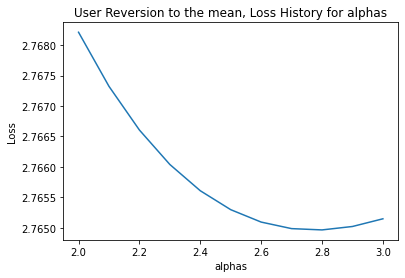

In [22]:
plt.plot(refined_list_alphas,history_v2)
plt.xlabel('alphas')
plt.ylabel('Loss')
plt.title("User Reversion to the mean, Loss History for alphas")
plt.show()

And thus we have found our absolute best alpha. Now we move on to using the book mean instead of the ise

### Book Reversion to the Mean

#### Tuning

In [23]:
M = train_ratings['ratings'].mean()
alpha_list = [0.1,0.5,1,2,3,4,5,6,7,M,8,9,10,15]
ba, history = reversion_train_tune_alphas(train_ratings, val_ratings, alphas=alpha_list, \
                                              column_for_reversion='ISBN', verbose=True)

  0%|          | 0/14 [00:00<?, ?it/s]

New Users:  22500
Alpha:  0.1
CV Error:  3.7759026174277808
Best Alpha:  0.1
New Users:  22500
Alpha:  0.5
CV Error:  3.5753700304860705
Best Alpha:  0.5
New Users:  22500
Alpha:  1
CV Error:  3.4652284067845858
Best Alpha:  1
New Users:  22500
Alpha:  2
CV Error:  3.37891094246767
Best Alpha:  2
New Users:  22500
Alpha:  3
CV Error:  3.3460897459132615
Best Alpha:  3
New Users:  22500
Alpha:  4
CV Error:  3.330611374507982
Best Alpha:  4
New Users:  22500
Alpha:  5
CV Error:  3.3225391270277544
Best Alpha:  5
New Users:  22500
Alpha:  6
CV Error:  3.318159607282052
Best Alpha:  6
New Users:  22500
Alpha:  7
CV Error:  3.315811426727825
Best Alpha:  7
New Users:  22500
Alpha:  7.60264355273723
CV Error:  3.3150079588184087
Best Alpha:  7.60264355273723
New Users:  22500
Alpha:  8
CV Error:  3.3146574184234585
Best Alpha:  8
New Users:  22500
Alpha:  9
CV Error:  3.314238614140701
Best Alpha:  9
New Users:  22500
Alpha:  10
CV Error:  3.3142871166592767
Best Alpha:  9
New Users:  22500


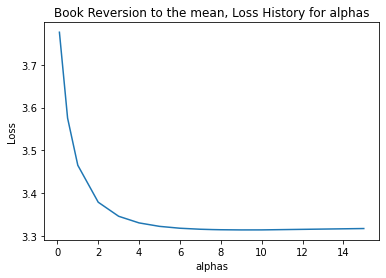

In [24]:
plt.plot(alpha_list,history)
plt.xlabel('alphas')
plt.ylabel('Loss')
plt.title("Book Reversion to the mean, Loss History for alphas")
plt.show()

Here there doesn't seem to be a very clear best alpha: the minimum seems to be around 8, so lets try refining our search around those values of alpha.

In [25]:
refined_list_alphas=[7,7.1,7.1,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8]
best_alpha_book, history_v2 = reversion_train_tune_alphas(train_ratings, val_ratings, alphas=refined_list_alphas, \
                                              column_for_reversion='ISBN', verbose=True)

  0%|          | 0/11 [00:00<?, ?it/s]

New Users:  22500
Alpha:  7
CV Error:  3.315811426727825
Best Alpha:  7
New Users:  22500
Alpha:  7.1
CV Error:  3.315651967222963
Best Alpha:  7.1
New Users:  22500
Alpha:  7.1
CV Error:  3.315651967222963
Best Alpha:  7.1
New Users:  22500
Alpha:  7.3
CV Error:  3.315365774947898
Best Alpha:  7.3
New Users:  22500
Alpha:  7.4
CV Error:  3.315238003109097
Best Alpha:  7.4
New Users:  22500
Alpha:  7.5
CV Error:  3.315119802548257
Best Alpha:  7.5
New Users:  22500
Alpha:  7.6
CV Error:  3.315010722621058
Best Alpha:  7.6
New Users:  22500
Alpha:  7.7
CV Error:  3.314910337079691
Best Alpha:  7.7
New Users:  22500
Alpha:  7.8
CV Error:  3.314818242520079
Best Alpha:  7.8
New Users:  22500
Alpha:  7.9
CV Error:  3.3147340569435673
Best Alpha:  7.9
New Users:  22500
Alpha:  8
CV Error:  3.3146574184234585
Best Alpha:  8


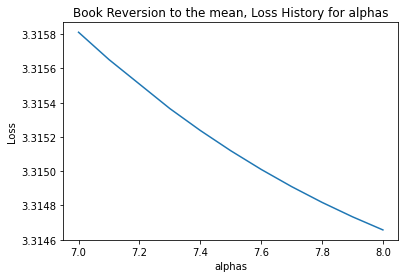

In [26]:
plt.plot(refined_list_alphas,history_v2)
plt.xlabel('alphas')
plt.ylabel('Loss')
plt.title("Book Reversion to the mean, Loss History for alphas")
plt.show()

So it seems our best alpha is 8. Now we find the results on the test set

### Reversion models on Test set

In [27]:
user_reversion_test_mse = reversion_on_new_data(train_ratings, ratings_test, best_alpha_user)
user_reversion_test_mse

2.7295868712668634

In [28]:
book_reversion_test_mse = reversion_on_new_data(train_ratings, ratings_test, best_alpha_book, column_for_reversion="ISBN")
book_reversion_test_mse

3.288606401598173

Here we see that the user reversion model gives better test mse than using book reversion, and better than our best naive model. This promising news. The User reversion to the mean is, currently, our best model. Now we move on to trying factor models, and aim to beat the mse of 2.34.

## Factor Models On Residuals

While we can use factor models to model the ratings, let us take a different approach. Since we already have some base models above, let us take our best performing model, the user reversion model and use factor models to model the residuals from that user reversion model. Let $\hat{R}_{u,b}^{rev}$ be the user reversion model's predictions and let 
$$
r_{u,b} = R_{u,b} - \hat{R}_{u,b}^{rev}
$$
be the residuals from the user reversion model.

We want to use factor models to obtain $\hat{r}_{u,b}$ that can approximate as closely as possible, the residuals $r_{u,b} \approx \hat{r}_{u,b}$ , so that
$$
R_{u,b} \approx \hat{R}_{u,b} = \hat{R}_{u,b}^{(naive)} + \hat{r}_{u,b}
$$
Thus, our loss function is:
$$
L(\hat{r}_{u,b}) = \frac{1}{|J|} \sum_{(u,b)\in{J}} (\hat{r}_{u,b} - r_{u,b})^2
$$
Using factor models, we can approximate $\hat{r}_{u,b}$ as the dot product between some weights for each user and each book:
$\hat{r}_{u,b} = \langle w_{u},w_{b} \rangle $
and with $\theta = \{w_{u}\} \bigcup \{w_{b}\}$, 
our problem becomes:
$$
min_{\theta}L(\theta) = \frac{1}{|J|} \sum_{(u,b)\in{J}} (\langle w_{u},w_{b} \rangle - r_{u,b})^2
$$

### Constructing Residuals


Before we begin defining our loss and training functions, we first construct appropriate dataframes that contains, for each entry, the associated residual. It is important to note that because of the pandas merge operation on dataframes in the reversion model functions for training and prediction, the predicted rhat from these models does not match the order given in the original train, test and val sets. I.e, if we extracted the predicted ratings from this model as a pandas.Series and added it to the original train, val, test dataframes, we would obtain inaccurate residuals.

This is the reason we construct new dataframes.

In [29]:
def add_residuals(train, new_data):
    r_hat_df = reversion_on_new_data_predict_df(train, new_data, best_alpha_user, column_for_reversion='user')
    r_hat_df['r_ub'] = r_hat_df['R_hat'] - r_hat_df['ratings'] 
    
    # sanity check
    print(loss(r_hat_df['R_hat'], r_hat_df['ratings']) == (r_hat_df['r_ub']**2).mean())
    return r_hat_df

train_w_residuals = add_residuals(train_ratings, train_ratings)
val_w_residuals = add_residuals(train_ratings, val_ratings)
test_w_residuals = add_residuals(train_ratings, ratings_test)

Loss on new data:  2.242390809769963
True
Loss on new data:  2.7649668149467854
True
Loss on new data:  2.7295868712668634
True


In [34]:
val_w_residuals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60714 entries, 0 to 100693
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user     60714 non-null  int64  
 1   R_hat    60714 non-null  float64
 2   ratings  60714 non-null  float64
 3   ISBN     60714 non-null  object 
 4   r_ub     60714 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.8+ MB


In [35]:
train_w_residuals.head()

,user,R_hat,ratings,ISBN,r_ub
0,8,6.659912,5,0887841740,1.659912
1,8,6.659912,6,1567407781,0.659912
2,8,6.659912,7,1881320189,-0.340088
3,8,6.659912,6,1575663937,0.659912
4,12,8.233527,10,1879384493,-1.766473


### Setting up Loss and Minimisation functions



Note: L-BFGS-B needs grad_wrapper to return a numpy array! So must convert result to numpy array to prevent weird errors.

In [30]:
@jax.jit
def factor_loss_single(r_ub, indices, W_u, W_b):
    w_u = W_u[indices[0]]
    w_b = W_b[indices[1]]
    return (r_ub - jnp.dot(w_u, w_b))**2

# vectorize the single loss on whole dataset
# map over residual, user weight matrix and book weight matrix
factor_loss_on_whole = jax.jit(jax.vmap(factor_loss_single, in_axes=(0,0,None,None)))

@jax.jit
def factor_loss_regularised(r_ub_vec, user_book_indices_vec, W_u, W_b, reg=0): # Loss function, default is no regularization
    '''
    Construct factor loss and add penalty
    '''
    N_u = len(W_u)
    N_b = len(W_b)
    list_of_all_losses = factor_loss_on_whole(r_ub_vec, user_book_indices_vec, W_u, W_b)
    return jnp.mean(list_of_all_losses) + (reg/N_u)*jnp.sum(W_u**2) + (reg/N_b)*jnp.sum(W_b**2)


grad_loss_wrt_u = jax.jit(jax.grad(factor_loss_regularised,argnums=2))
grad_loss_wrt_b = jax.jit(jax.grad(factor_loss_regularised,argnums=3))

def minimize_wrt_b(r_ub_vec, user_book_indices_vec, W_u, W_b, penalty=0, n_iter=15, algo="TNC"):
    # TODO fix using L-BFGS-B
    r,d = W_b.shape
    def loss_wrapper(W_b_flat):
        W_b = W_b_flat.reshape(r,d)
        return factor_loss_regularised(r_ub_vec, user_book_indices_vec, W_u, W_b, penalty)
    def grad_wrapper_W_b(W_b_flat):
        W_b = W_b_flat.reshape(r,d)
        return onp.array(grad_loss_wrt_b(r_ub_vec, user_book_indices_vec, W_u, W_b, penalty))
    
    result = scipy.optimize.minimize(fun = loss_wrapper, 
                                     x0 = W_b.ravel(), method=algo,
                                     jac=grad_wrapper_W_b,options={"maxiter":n_iter})
    
    W_b_soln = result["x"].reshape(r,d)
    return W_b_soln

def minimize_wrt_u(r_ub_vec, user_book_indices_vec, W_u, W_b, penalty=0, n_iter=15, algo="TNC"):
    
    r,d = W_u.shape
    def loss_wrapper(W_u_flat):
        W_u = W_u_flat.reshape(r,d)
        return factor_loss_regularised(r_ub_vec, user_book_indices_vec, W_u, W_b, penalty)
    def grad_wrapper_W_u(W_u_flat):
        W_u = W_u_flat.reshape(r,d)
        return onp.array(grad_loss_wrt_u(r_ub_vec, user_book_indices_vec, W_u, W_b, penalty))
    result = scipy.optimize.minimize(fun = loss_wrapper, 
                                     x0 = W_u.ravel(), method=algo,
                                     jac=grad_wrapper_W_u,options={"maxiter":n_iter})
    W_u_soln = result["x"].reshape(r,d)
    return W_u_soln

def factor_model_predict_single(index, W_u, W_b, M):
    if index[0] == None:
        return M
    return onp.dot(W_u[index[0]], W_b[index[1]])     
    
def factor_model_predict(M, indices, W_u, W_b):
    return onp.array(list(map(lambda x: factor_model_predict_single(x, W_u, W_b, M), indices)))

### Training Function

In [31]:

def train_tune_factor_model(train, val, response='ratings',seed=4212, reg=0, d_values=[1,3],\
                            n_iter=10, optim_iter=20, verbose=False):
    
    # init variables
    M_response = train[response].mean()
    N_users = len(train['user'].unique())
    N_books = len(train['ISBN'].unique())
    min_loss = 1000
    best_d = d_values[0]
    all_train_loss_history = []
    all_val_loss_history = []
    
    # handle indices
    user_to_row = {k:v for v, k in enumerate(train['user'].unique())}
    ISBN_to_row = {k:v for v, k in enumerate(train['ISBN'].unique())}
    data_to_indices = lambda x, y: (user_to_row[x], ISBN_to_row[y])
    def data_to_indices(user, ISBN):
        try:
            user_index = user_to_row[user]
            book_index = ISBN_to_row[ISBN]
        except: # KeyError
            return (None, None)
        return (user_index, book_index)
        
    train_indices = onp.array(list(map(data_to_indices,\
                                      train['user'], train['ISBN'])))
    val_indices = onp.array(list(map(data_to_indices,\
                                      val['user'], val['ISBN'])))
    test_indices = onp.array(list(map(data_to_indices,\
                                      test_w_residuals['user'], test_w_residuals['ISBN'])))
    
    # tuning to select d
    for d in d_values:
        # Initialize history
        train_loss_history = []
        val_loss_history = []

        # Initialize w_u and w_b
        onp.random.seed(seed)
        w_u_init = onp.random.normal(M_response/d,1/d,size=(N_users,d))
        w_b_init = onp.random.normal(M_response/d,1/d,size=(N_books,d))
        W_u = onp.copy(w_u_init)
        W_b = onp.copy(w_b_init)

        for k in range(n_iter):

            # Alternate minimizations to train U and B
            W_b = minimize_wrt_b(train[response].values,train_indices,W_u,W_b,penalty=reg,n_iter=optim_iter)
            W_u = minimize_wrt_u(train[response].values,train_indices,W_u,W_b,penalty=reg,n_iter=optim_iter)

            # Save loss history
            yhat_train = factor_model_predict(M_response, train_indices, W_u, W_b)
            current_train_loss = loss(yhat_train, train[response])
            train_loss_history.append(current_train_loss)
            
            yhat_val = factor_model_predict(M_response, val_indices, W_u, W_b)
            # print(yhat_val.shape)
            # print(val['r_ub'])
            current_val_loss = loss(yhat_val, val[response])
            val_loss_history.append(current_val_loss)
            
            if verbose:
                print("Current d: ", d)
                print("Current iter: ", k)
                print("Train loss:{0:.3f} \t Validation Loss:{1:.3f}".format(current_train_loss,current_val_loss))
            
        # Save all the loss histories for each d
        all_train_loss_history.append(train_loss_history)
        all_val_loss_history.append(val_loss_history)

        # Save the best d and the corresponding W_u and W_b when val_loss is the lowest
        if (current_val_loss < min_loss):
            minLoss = current_val_loss
            best_d = d
            best_W_u = W_u
            best_W_b = W_b

    return all_train_loss_history, all_val_loss_history, best_d, best_W_u, best_W_b

### Training Factor model - No regularisation

First, let us train our non-regularised model. While it is obvious that overfitting will occur, we also want a baseline of what our regularised model should try to beat, and we would also like an idea of how bad the overfitting is. And perhaps it would also be enjoyable to see how low our train error can go.

In [32]:
list_of_d = [1,3,5,10, 15, 20, 25, 50]
all_train_history_0, all_val_history_0, best_d_0, \
best_W_u_0, best_W_b_0 = train_tune_factor_model(train_w_residuals, val_w_residuals, d_values=list_of_d,\
                                             n_iter=15, optim_iter=20,response='r_ub', reg=0, verbose=True)

Current d:  1
Current iter:  0
Train loss:2.123 	 Validation Loss:2.885
Current d:  1
Current iter:  1
Train loss:1.813 	 Validation Loss:3.013
Current d:  1
Current iter:  2
Train loss:1.441 	 Validation Loss:3.177
Current d:  1
Current iter:  3
Train loss:1.239 	 Validation Loss:3.295
Current d:  1
Current iter:  4
Train loss:1.083 	 Validation Loss:3.411
Current d:  1
Current iter:  5
Train loss:0.944 	 Validation Loss:3.568
Current d:  1
Current iter:  6
Train loss:0.904 	 Validation Loss:3.645
Current d:  1
Current iter:  7
Train loss:0.823 	 Validation Loss:3.859
Current d:  1
Current iter:  8
Train loss:0.773 	 Validation Loss:4.158
Current d:  1
Current iter:  9
Train loss:0.743 	 Validation Loss:4.429
Current d:  1
Current iter:  10
Train loss:0.726 	 Validation Loss:4.721
Current d:  1
Current iter:  11
Train loss:0.709 	 Validation Loss:4.986
Current d:  1
Current iter:  12
Train loss:0.696 	 Validation Loss:5.300
Current d:  1
Current iter:  13
Train loss:0.687 	 Validation

Current d:  50
Current iter:  8
Train loss:0.000 	 Validation Loss:3.084
Current d:  50
Current iter:  9
Train loss:0.000 	 Validation Loss:3.084
Current d:  50
Current iter:  10
Train loss:0.000 	 Validation Loss:3.084
Current d:  50
Current iter:  11
Train loss:0.000 	 Validation Loss:3.084
Current d:  50
Current iter:  12
Train loss:0.000 	 Validation Loss:3.084
Current d:  50
Current iter:  13
Train loss:0.000 	 Validation Loss:3.084
Current d:  50
Current iter:  14
Train loss:0.000 	 Validation Loss:3.084


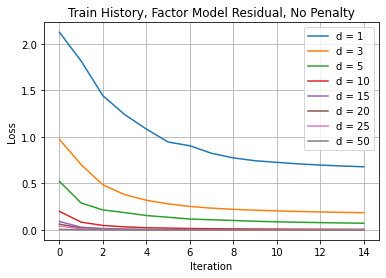

In [33]:
for i in range(len(all_train_history_0)):
    plt.plot(all_train_history_0[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Train History, Factor Model Residual, No Penalty")
plt.show()

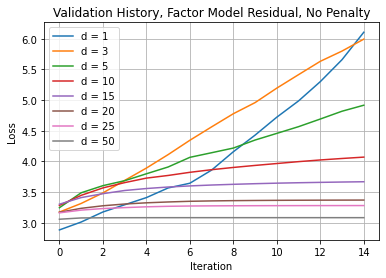

In [34]:
for i in range(len(all_val_history_0)):
    plt.plot(all_val_history_0[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Validation History, Factor Model Residual, No Penalty")
plt.show()

As we can see from above, validation error increases greatly, indicating overfitting on train data for all models, even d=1! Meanwhile, using d=25, 50, train error dropped eventually to 0.000 at different speeds, indicating miniscule train error. The most interesting observation here however, is that validation loss after all our iterations is actually lowest for d=50 which is the model with the **most** parameters, and not only that, but for models with $d \geq 10$, the higher the d, the more stable the validation error, although we note here that validation error remains constant at best.

### Training Factor Models with Regularisation

Now we work with penalised models in a bid to obtain better validation error: with our non-penalised model, we actually obtain validation error **higher** than our user reversion to the mean model. This is not a good final model. Thus we explore models with different penalties to find a sweet spot model that would generalise well to our test data.

#### Penalty = 2

In [ ]:
all_train_history_2, all_val_history_2, best_d_2, \
best_W_u_2, best_W_b_2 = train_tune_factor_model(train_w_residuals, val_w_residuals, d_values=list_of_d,\
                                             n_iter=15, optim_iter=20,response='r_ub', reg=2, verbose=True)

Current d:  1
Current iter:  0
Train loss:2.067 	 Validation Loss:2.790
Current d:  1
Current iter:  1
Train loss:1.806 	 Validation Loss:2.835
Current d:  1
Current iter:  2
Train loss:1.712 	 Validation Loss:2.869
Current d:  1
Current iter:  3
Train loss:1.676 	 Validation Loss:2.887
Current d:  1
Current iter:  4
Train loss:1.651 	 Validation Loss:2.902
Current d:  1
Current iter:  5
Train loss:1.637 	 Validation Loss:2.913
Current d:  1
Current iter:  6
Train loss:1.629 	 Validation Loss:2.922
Current d:  1
Current iter:  7
Train loss:1.624 	 Validation Loss:2.929
Current d:  1
Current iter:  8
Train loss:1.621 	 Validation Loss:2.934
Current d:  1
Current iter:  9
Train loss:1.619 	 Validation Loss:2.939
Current d:  1
Current iter:  10
Train loss:1.617 	 Validation Loss:2.943
Current d:  1
Current iter:  11
Train loss:1.615 	 Validation Loss:2.946
Current d:  1
Current iter:  12
Train loss:1.614 	 Validation Loss:2.949
Current d:  1
Current iter:  13
Train loss:1.613 	 Validation

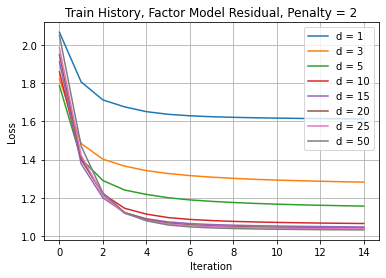

In [ ]:
for i in range(len(all_train_history_2)):
    plt.plot(all_train_history_2[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Train History, Factor Model Residual, Penalty = 2")
plt.show()

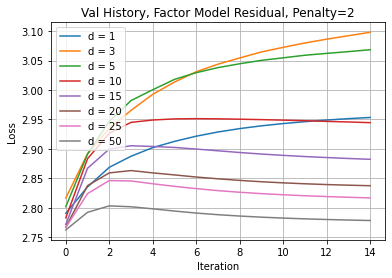

In [ ]:
for i in range(len(all_val_history_2)):
    plt.plot(all_val_history_2[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Val History, Factor Model Residual, Penalty=2")
plt.show()

#### Penalty = 3

In [ ]:
all_train_history_3, all_val_history_3, best_d_3, \
best_W_u_3, best_W_b_3 = train_tune_factor_model(train_w_residuals, val_w_residuals, d_values=list_of_d,\
                                             n_iter=15, optim_iter=20,response='r_ub', reg=3, verbose=True)

Current d:  1
Current iter:  0
Train loss:2.110 	 Validation Loss:2.784
Current d:  1
Current iter:  1
Train loss:1.931 	 Validation Loss:2.804
Current d:  1
Current iter:  2
Train loss:1.873 	 Validation Loss:2.823
Current d:  1
Current iter:  3
Train loss:1.848 	 Validation Loss:2.836
Current d:  1
Current iter:  4
Train loss:1.836 	 Validation Loss:2.844
Current d:  1
Current iter:  5
Train loss:1.828 	 Validation Loss:2.850
Current d:  1
Current iter:  6
Train loss:1.822 	 Validation Loss:2.856
Current d:  1
Current iter:  7
Train loss:1.818 	 Validation Loss:2.859
Current d:  1
Current iter:  8
Train loss:1.815 	 Validation Loss:2.862
Current d:  1
Current iter:  9
Train loss:1.813 	 Validation Loss:2.864
Current d:  1
Current iter:  10
Train loss:1.811 	 Validation Loss:2.866
Current d:  1
Current iter:  11
Train loss:1.810 	 Validation Loss:2.868
Current d:  1
Current iter:  12
Train loss:1.809 	 Validation Loss:2.869
Current d:  1
Current iter:  13
Train loss:1.808 	 Validation

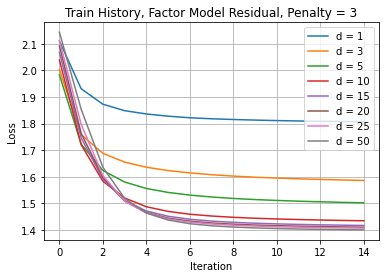

In [ ]:
for i in range(len(all_train_history_3)):
    plt.plot(all_train_history_3[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Train History, Factor Model Residual, Penalty = 3")
plt.show()

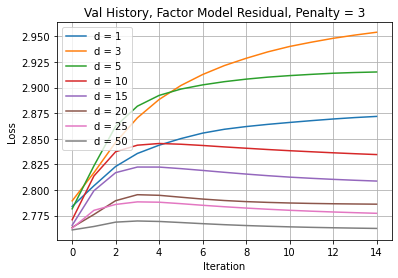

In [ ]:
for i in range(len(all_val_history_3)):
    plt.plot(all_val_history_3[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Val History, Factor Model Residual, Penalty = 3")
plt.show()

#### Penalty = 10

In [41]:
all_train_history_10, all_val_history_10, best_d_10, \
best_W_u_10, best_W_b_10 = train_tune_factor_model(train_w_residuals, val_w_residuals, d_values=list_of_d,\
                                             n_iter=15, optim_iter=20,response='r_ub', reg=10, verbose=True)

Current d:  1
Current iter:  0
Train loss:2.219 	 Validation Loss:2.764
Current d:  1
Current iter:  1
Train loss:2.151 	 Validation Loss:2.764
Current d:  1
Current iter:  2
Train loss:2.140 	 Validation Loss:2.764
Current d:  1
Current iter:  3
Train loss:2.131 	 Validation Loss:2.764
Current d:  1
Current iter:  4
Train loss:2.127 	 Validation Loss:2.764
Current d:  1
Current iter:  5
Train loss:2.125 	 Validation Loss:2.764
Current d:  1
Current iter:  6
Train loss:2.124 	 Validation Loss:2.764
Current d:  1
Current iter:  7
Train loss:2.124 	 Validation Loss:2.764
Current d:  1
Current iter:  8
Train loss:2.124 	 Validation Loss:2.764
Current d:  1
Current iter:  9
Train loss:2.124 	 Validation Loss:2.764
Current d:  1
Current iter:  10
Train loss:2.124 	 Validation Loss:2.764
Current d:  1
Current iter:  11
Train loss:2.123 	 Validation Loss:2.764
Current d:  1
Current iter:  12
Train loss:2.123 	 Validation Loss:2.764
Current d:  1
Current iter:  13
Train loss:2.123 	 Validation

Current d:  50
Current iter:  8
Train loss:2.105 	 Validation Loss:2.760
Current d:  50
Current iter:  9
Train loss:2.105 	 Validation Loss:2.760
Current d:  50
Current iter:  10
Train loss:2.105 	 Validation Loss:2.760
Current d:  50
Current iter:  11
Train loss:2.104 	 Validation Loss:2.760
Current d:  50
Current iter:  12
Train loss:2.104 	 Validation Loss:2.760
Current d:  50
Current iter:  13
Train loss:2.104 	 Validation Loss:2.760
Current d:  50
Current iter:  14
Train loss:2.104 	 Validation Loss:2.760


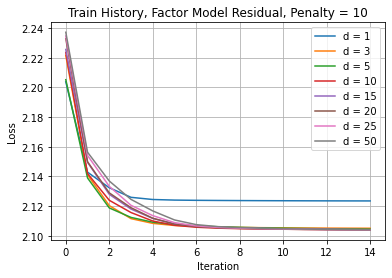

In [ ]:
for i in range(len(all_train_history_10)):
    plt.plot(all_train_history_10[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Train History, Factor Model Residual, Penalty = 10")
plt.show()

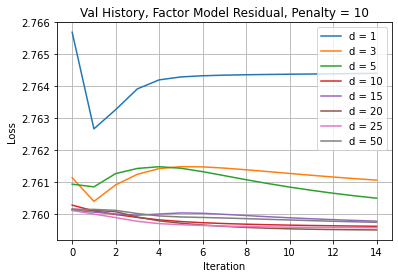

In [ ]:
for i in range(len(all_val_history_10)):
    plt.plot(all_val_history_10[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Val History, Factor Model Residual, Penalty = 10")
plt.show()

#### Penalty = 4.5

In [36]:
all_train_history_4, all_val_history_4, best_d_4, \
best_W_u_4, best_W_b_4 = train_tune_factor_model(train_w_residuals, val_w_residuals, d_values=list_of_d,\
                                             n_iter=15, optim_iter=20,response='r_ub', reg=4.5, verbose=True)

Current d:  1
Current iter:  0
Train loss:2.160 	 Validation Loss:2.777
Current d:  1
Current iter:  1
Train loss:2.045 	 Validation Loss:2.786
Current d:  1
Current iter:  2
Train loss:2.006 	 Validation Loss:2.792
Current d:  1
Current iter:  3
Train loss:1.995 	 Validation Loss:2.796
Current d:  1
Current iter:  4
Train loss:1.988 	 Validation Loss:2.800
Current d:  1
Current iter:  5
Train loss:1.983 	 Validation Loss:2.802
Current d:  1
Current iter:  6
Train loss:1.979 	 Validation Loss:2.804
Current d:  1
Current iter:  7
Train loss:1.976 	 Validation Loss:2.805
Current d:  1
Current iter:  8
Train loss:1.974 	 Validation Loss:2.807
Current d:  1
Current iter:  9
Train loss:1.972 	 Validation Loss:2.808
Current d:  1
Current iter:  10
Train loss:1.971 	 Validation Loss:2.809
Current d:  1
Current iter:  11
Train loss:1.969 	 Validation Loss:2.810
Current d:  1
Current iter:  12
Train loss:1.968 	 Validation Loss:2.811
Current d:  1
Current iter:  13
Train loss:1.967 	 Validation

Current d:  50
Current iter:  8
Train loss:1.774 	 Validation Loss:2.759
Current d:  50
Current iter:  9
Train loss:1.769 	 Validation Loss:2.759
Current d:  50
Current iter:  10
Train loss:1.766 	 Validation Loss:2.759
Current d:  50
Current iter:  11
Train loss:1.764 	 Validation Loss:2.758
Current d:  50
Current iter:  12
Train loss:1.762 	 Validation Loss:2.758
Current d:  50
Current iter:  13
Train loss:1.761 	 Validation Loss:2.758
Current d:  50
Current iter:  14
Train loss:1.760 	 Validation Loss:2.758


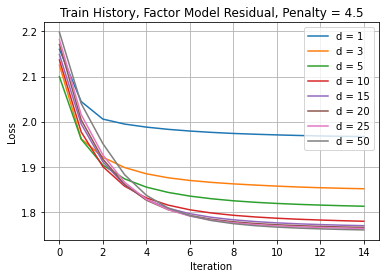

In [37]:
for i in range(len(all_train_history_4)):
    plt.plot(all_train_history_4[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Train History, Factor Model Residual, Penalty = 4.5")
plt.show()

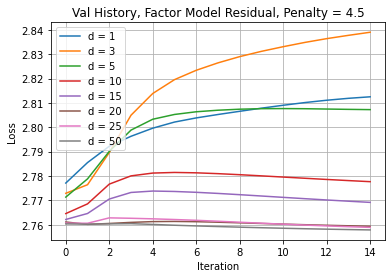

In [38]:
for i in range(len(all_val_history_4)):
    plt.plot(all_val_history_4[i], label="d = {DD}".format(DD=list_of_d[i]))
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Iteration")
    plt.title("Val History, Factor Model Residual, Penalty = 4.5")
plt.show()

We can see that using lower penalty of 2, 3 yields validation loss histories that are not promising: they start low and increase, and while the validation error does not explode, it still seems to indicate overfitting. Of interest here is also the fact that our highest value of d, 50, still yields the lowest train and val error.

So how about much higher penalties?

Utitlising a penalty of 10, we obtain a much better validation loss history and lower validation loss compared to a penalty of 2-3. However, validation loss is actually lower at 4.5 than 10 for our best model,  d=50, at 2.758 instead of 2.76 at a penalty of 10. Additionally, training loss actually suffers much more. At a penalty value of 4.5, train error reaches a min of around 1.76, but for a penalty value of 10 it only reaches 2.11. This is not a good sign either.

Thus we seek the middle ground: a penalty of 4.5. This looks slightly random, but is one of the lowest penalties for which the validation loss history for d=50, our best performing model, actually shows a nice decrease. It also obtains the best validation error so far among all other models and penalties. This becomes the final model we evaluate our test set on.

## Final Model: Factor Model On Residuals, d = 50, penalty = 4.5

In [44]:
# handle indices
user_to_row = {k:v for v, k in enumerate(train_w_residuals['user'].unique())}
ISBN_to_row = {k:v for v, k in enumerate(train_w_residuals['ISBN'].unique())}
def data_to_indices(user, ISBN):
    try:
        user_index = user_to_row[user]
        book_index = ISBN_to_row[ISBN]
    except: # KeyError
        return (None, None)
    return (user_index, book_index)
test_indices = onp.array(list(map(data_to_indices,\
                                      test_w_residuals['user'], test_w_residuals['ISBN'])))
yhat_test = factor_model_predict(train_w_residuals['r_ub'].mean(), test_indices, best_W_u_4, best_W_b_4)
current_test_loss = loss(yhat_test, test_w_residuals['r_ub'])
current_test_loss

2.7199231210875108

And here we see the merits of our best model on the test set as well: it achieves a test error of 1.95, much lower than our reversion to the mean model which was what we modelled our residuals on. This thus becomes our final model: we first use user reversion to the mean, use a factor model to model the residuals and add that to the rating to obtain our final prediction for ratings.